## ■ Why
이유 or 배경

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
# from flask import Flask, render_template, request
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,explained_variance_score, mean_squared_log_error, median_absolute_error
from sklearn.preprocessing import StandardScaler
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
person_data = pd.read_csv('./data/population.csv')

In [6]:
years = ['13','14','15','16','17', '18', '19', '20', '21', '22', '23']


data_frames = {}

for year in years:
    file_name = f'./data/{year}년.csv'
    try:
        data_frames[f'df{year}'] = pd.read_csv(file_name, encoding='utf-8')
    except UnicodeDecodeError:
        data_frames[f'df{year}'] = pd.read_csv(file_name, encoding='euc-kr')

In [7]:
for year in years:
     data_frames[f'df{year}'] =  data_frames[f'df{year}'][ data_frames[f'df{year}']['시군구'].str.contains('의정부')].iloc[:, :-4].drop(['번지', '본번', '부번', '계약일'], axis=1)
    
     data_frames[f'df{year}'] =  data_frames[f'df{year}'].reset_index(drop=True)

     data_frames[f'df{year}']['거래금액(만원)'] =  data_frames[f'df{year}']['거래금액(만원)'].str.replace(',', '').astype(int)

     data_frames[f'df{year}']["시군구"] =  data_frames[f'df{year}']["시군구"].apply(lambda x: x.split()[2])

     data_frames[f'df{year}'].head(2)

     data_frames[f'df{year}']["전용면적(평)"] = ( data_frames[f'df{year}']['전용면적(㎡)'] / 3.3).round(0).astype(int)

In [8]:
for year in years:
    data_frames[f'df{year}']['전용면적(평범위)']=pd.cut(data_frames[f'df{year}']['전용면적(평)'], bins=[0, 10, 20, 30, 40, float('inf')], labels=['10평미만', '10~20평', '20~30평', '30~40평', '40평이상'])

    data_frames[f'df{year}']['연도'] = year

In [9]:
data_frames['df13'].head(4)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도
0,가능동,SKVIEW,59.9800,201301,21600,10,2007,신촌로 18-7,18,10~20평,13
1,가능동,가재울일신건영휴먼빌,59.9929,201301,18000,20,2007,평화로658번길 50,18,10~20평,13
2,가능동,금용,84.7200,201301,18000,5,1996,태평로184번길 21-4,26,20~30평,13
3,가능동,브라운스톤흥선,59.9860,201301,19000,7,2008,호국로1142번길 22,18,10~20평,13


In [10]:
# data_frames 딕셔너리에서 각 년도별 데이터프레임을 리스트로 추출합니다.
data_frames_list = list(data_frames.values())

# 데이터프레임들을 하나로 합칩니다.
combined_df = pd.concat(data_frames_list, ignore_index=True)

# 결과 확인
combined_df['전용면적(㎡)'] = combined_df['전용면적(㎡)'].round(2) 
combined_df.head(2)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도
0,가능동,SKVIEW,59.98,201301,21600,10,2007.0,신촌로 18-7,18,10~20평,13
1,가능동,가재울일신건영휴먼빌,59.99,201301,18000,20,2007.0,평화로658번길 50,18,10~20평,13


In [11]:
dong_mapping = {
    'SKVIEW': '가능동',
    '가재울일신건영휴먼빌': '가능동',
    '금용': '가능동',
    '브라운스톤흥선': '가능동',
    '일심': '흥선동',
    '금광포란재이너스' : '가능동',
    '동원': '가능동',
    '신동아파라디움': '흥선동',
    '행복한세상': '가능동',
    '유성벨로스' : '가능동',
    '녹양2차동원아파트': '가능동',
    '문화늘푸른': '가능동',
    '신도': '가능동',
    '궁전' : '흥선동',
    '오성이큐빌': '의정부1동',
    '동일수정':'가능동',
    '동성아파트(102동)':'가능동',
    '청솔' : '흥선동',
    '가능신진': '흥선동',
    '동성아파트(101동)' : '가능동',
    'E.Q.빌아파트':'의정부1동',
    '희망':'가능동',
    '힐스테이트녹양역': '가능동',
    'e편한세상녹양역': '가능동',
    '더샵파크에비뉴' : '흥선동',
    '금오2차신도브래뉴업':'자금동',
    '금오주공그린빌1':'자금동',
    '벽산블루밍':'자금동',
    '신도브래뉴1차':'자금동',
    '파스텔':'자금동',
    '현대아이파크':'자금동',
    '거성':'자금동',
    '금오주공그린빌3':'자금동',
    '세아':'자금동',
    '평화':'자금동',
    '우암센스뷰':'자금동',
    '케이에스씨':'자금동',
    '아남주상복합':'자금동',
    '녹양힐스테이트':'녹양동',
    '청구':'녹양동',
    '휴먼시아(3단지)':'녹양동',
    '휴먼시아(4단지)':'녹양동',
    '영무예다음':'녹양동',
    '현대':'녹양동',
    '대림':'녹양동',
    '신도9':'녹양동',
    '산들마을(길훈)':'송산2동', '산들마을(신안)':'송산2동', '산들마을(현대)':'송산2동', '산들마을4단지아이파크':'송산2동', '송산대우푸르지오':'송산2동',
    '송산센트럴아파트':'송산2동', '송산주공4단지':'송산2동', '송산팰리스':'송산2동', '주공':'송산2동', '한라비발디':'송산2동', '민락e-편한세상':'송산2동',
    '송산 그랜드캐슬아파트':'송산2동', '송산리버빌아파트':'송산2동', '청구1차':'송산2동', '산들마을(서광)':'송산2동', '산들마을(청구)':'송산2동',
    '민락센트럴15단지':'송산2동', '민락센트럴17단지':'송산2동', '호반베르디움1차':'송산2동', '민락엘레트':'송산2동', '민락2지구18단지호반베르디움':'송산2동',
    '의정부민락우미린더스카이':'송산2동',
    '의정부민락푸르지오':'송산2동', '의정부민락금강펜테리움아파트':'송산2동', '반도유보라아이비파크':'송산2동', '호반베르디움２차':'송산2동',
    '대광로제비앙포레스트':'송산2동', '엘에이치휴스토리':'송산2동',
    '건영':'송산1동', '그랜드':'송산1동', '보광':'송산1동', '송산주공1단지':'송산1동', '신도10차파크힐타운':'송산1동', '신도브래뉴아파트':'송산1동', '용현동건영캐스빌':'송산1동',
    '용현주공':'송산1동', '용현현대1차':'송산1동', '용현동신도브래뉴PLUS':'송산1동', '용현세아1차':'송산1동', '용현현대2차':'송산1동', '장미1':'송산1동',
    '동문1단지':'송산1동', '장미2':'송산1동', '용현세아2차':'송산1동', '동문2단지':'송산1동', '금용':'송산1동', '산호':'송산1동', '베르우스M':'송산1동', '애디안아파트':'송산1동',
    '웰링턴':'송산1동', '탑석센트럴자이':'송산1동','대광로제비앙더퍼스트':'송산1동', '의정부고산대방노블랜드에듀파크아파트':'송산1동', '고산리슈빌포레':'송산1동','대광로제비앙더퍼스트':'송산1동',
    '동아':'장암동', '삼환나우빌':'장암동', '수락리버시티1단지':'장암동', '신곡우성':'장암동', '장암1차푸르지오':'장암동', '장암주공2':'장암동', '장암주공7':'장암동',
    '수락리버시티2단지':'장암동', '장암2차푸르지오':'장암동', '장암더샵포레스트':'장암동',
    '극동':'신곡2동', '극동스타클래스':'신곡1동', '금오풍림':'신곡1동', '대우':'신곡1동', '드림밸리':'신곡2동', '삼도세라믹':'신곡2동', '삼성래미안진흥':'신곡2동', '삼익':'신곡1동',
    '삼환':'신곡2동', '상록아이파크':'신곡2동', '성원':'신곡1동', '성원2':'신곡2동', '신곡건영':'신곡2동', '신곡동신':'신곡2동', '신곡서해':'신곡1동', '신곡주공4':'신곡2동',
    '신곡현대':'신곡1동', '신동아파밀리에':'신곡1동', '신명':'신곡2동', '신명스카이뷰':'신곡2동', '신성':'신곡2동', '신일1':'신곡1동', '은하수':'신곡2동', '장암동신':'신곡1동',
    '장암주공5':'신곡1동', '장암현대2':'신곡1동', '주공그린빌4':'신곡2동', '풍림':'신곡1동', '한일유앤아이':'신곡1동', '현대3':'신곡1동', '동성':'신곡2동', '벽산':'신곡2동',
    '장암한국':'신곡1동', '장암현대1':'신곡1동', '추동':'신곡2동', '한일':'신곡1동', '벽산조합':'신곡2동', '부용':'신곡2동', '산호클래식':'신곡2동', '신곡동현진에버빌':'신곡1동',
    '신곡신일2':'신곡1동', '신명스카이뷰-2':'신곡1동', '신성2':'신곡2동', '삼부':'신곡2동', '파크힐(132-2)':'신곡2동', 'e편한세상신곡파크비스타':'신곡1동',
    'e편한세상신곡포레스타뷰':'신곡2동',
    'I-PARK':'호원1동', '건영':'호원1동', '뉴삼익호원2':'호원2동', '삼성미도':'호원2동', '신도101':'호원1동', '신도4':'호원2동', '신도6':'호원2동', '신원':'호원2동',
    '신일':'호원1동', '신일유토빌':'호원2동', '신일유토빌플러스':'호원1동', '쌍용':'호원2동', '우성1':'호원1동', '우성3':'호원1동', '우성5':'호원1동', '한승':'호원2동',
    '한아름월드':'호원1동', '한주4':'호원1동', '한주5':'호원2동', '호원가든1':'호원2동', '호원동한승미메이드':'호원2동', '호원두산':'호원2동', '호원풍림':'호원2동',
    '흥화브라운':'호원1동', '뉴익호원가든3':'호원2동', '삼익':'호원2동', '신도5':'호원2동', '신일엘리시움':'호원1동', '우남푸르미아':'호원1동', '푸른마을':'호원1동',
    '한국개나리':'호원2동', '한신2차':'호원2동', '한주1':'호원1동', '한주3':'호원1동', '회룡역풍림아이원':'호원2동', '롯데':'호원1동', '성호':'호원1동', '신도6-1':'호원2동',
    '우남':'호원2동', '우남2':'호원2동', '하늘빛(덕림)':'호원2동', '한신1차':'호원2동', '현대':'호원2동', '신도7':'호원1동', '쌍용스윗닷홈':'호원2동', '유원':'호원1동', '우성2':'호원1동',
    '회룡한주6차':'호원1동', '성호(443-0)':'호원1동', '양우내안애팰리스':'호원1동', '회룡타운':'호원2동', '한주4-1':'호원1동', '뉴삼익5차':'호원2동',
    '그랑베르':'호원1동', '르네상스시티':'호원1동', '신일골든휴아파트':'호원1동', '엘리시아':'호원1동', '서하뜰':'호원1동',
    '동화':'의정부2동', '디에스타워':'의정부1동', '미리온타워':'의정부1동', '신도2':'의정부1동', '신도3':'의정부1동', '토암비체':'의정부2동', '한솔그랑빌A':'의정부1동',
    '젠하우트(482-3)':'의정부2동', '한라비발디루트':'의정부1동', '다솜프라임':'의정부1동', '한솔그랑빌B':'의정부1동', '예체뜰안':'의정부1동', '해뜨는마을':'의정부1동',
    '신한헤스티아':'의정부2동', '대봉그린아파트':'의정부1동', '맥스타워':'의정부1동', '비비르파크':'의정부1동', '신도아크라티움':'의정부2동', '아이비타워':'의정부2동', '로즈데일':'의정부1동',
    '아토팰리스':'의정부1동', '남해오네뜨':'의정부2동', '대봉그린아파트B':'의정부1동', '우미쁘띠린1차':'의정부1동','우미쁘띠린2차':'의정부1동', '준성':'의정부2동', '아이프라자2':'의정부1동',
    '예체뜰안(188-5)':'의정부1동', '라움':'의정부1동', '의정부일성트루엘':'의정부2동', '현대그린':'의정부1동', '골든하우스':'의정부1동', '의정부동영무예다음':'의정부1동',
    '스카이파크':'의정부2동', '한솔리버시티':'의정부2동', '라임시티':'의정부1동', '비비르타워':'의정부1동', '승윤노블리안시티':'의정부1동', '드림타운':'의정부1동', 'JSBENEST':'의정부1동',
    '팰리체':'의정부2동', 'DS더웰가':'의정부1동', '효성팰리스':'의정부1동', '대상센트럴':'의정부1동', '이든타워':'의정부2동', '공간라움':'의정부1동', '라움M주상복합아파트':'의정부1동',
    '우주마루6차':'의정부1동', '메트로타워':'의정부1동', '부성파인':'의정부1동', '의정부롯데캐슬골드파크2단지':'의정부2동', '의정부롯데캐슬골드파크1단지':'의정부1동',
    '베르우스':'의정부1동', '더웰가2':'의정부1동', '스마트트라움':'의정부1동', '아이콘스타로데오':'의정부1동', '드어반트라움':'의정부1동', '럭스타워':'의정부2동',
    '승윤노블리안시티II':'의정부1동', '의정부한원힐트리움-더테라스':'의정부1동', '에버리치':'의정부1동', '아이콘스타리버뷰':'의정부1동', '의정부디베뉴스타':'의정부1동',
    '메트하임의정부':'의정부1동', '태림더끌리움씨티':'의정부2동', '아이콘스타센트럴':'의정부1동', '의정부역진산&월드메르디앙':'의정부1동', '의정부역코아루퍼스트원':'의정부2동',
    '한양수자인파크뷰':'의정부1동', '케렌시아433':'의정부2동', '의정부역센트럴자이&위브캐슬':'의정부1동', '이안더메트로':'의정부1동', '혜성루첸리':'의정부1동',
    '리버카운티':'의정부1동', '대가트라움':'의정부1동'
}

In [12]:
combined_df['행정동'] = combined_df['단지명'].map(dong_mapping)

In [13]:
combined_df.head(2)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동
0,가능동,SKVIEW,59.98,201301,21600,10,2007.0,신촌로 18-7,18,10~20평,13,가능동
1,가능동,가재울일신건영휴먼빌,59.99,201301,18000,20,2007.0,평화로658번길 50,18,10~20평,13,가능동


In [14]:
person_data = person_data.drop('항목',axis=1)
person_data.head(2)

,행정구역(동읍면)별,2013.01 월,2013.02 월,2013.03 월,2013.04 월,2013.05 월,2013.06 월,2013.07 월,2013.08 월,2013.09 월,...,2022.10 월,2022.11 월,2022.12 월,2023.01 월,2023.02 월,2023.03 월,2023.04 월,2023.05 월,2023.06 월,2023.07 월
0,의정부시,429361.0,429720.0,429852.0,430028.0,430019.0,429881.0,429866.0,429892.0,429907.0,...,463324.0,463789.0,463724.0,463353.0,463053.0,462637.0,462374.0,462329.0,463941.0,464775.0
1,의정부1동,20182.0,20174.0,20156.0,20171.0,20202.0,20108.0,20118.0,20133.0,20076.0,...,37106.0,37332.0,37444.0,37557.0,37609.0,37647.0,37615.0,37640.0,37575.0,37515.0


In [15]:
def rename_columns(person_data, old_name, new_name):
    person_data.rename(columns={old_name: new_name}, inplace=True)
    return person_data

person_data = rename_columns(person_data, '행정구역(동읍면)별', '행정동')

In [16]:
def rename_month_columns(dataframe):
    renamed_columns = {}
    for column_name in dataframe.columns:
        if '월' in column_name:
            year_month = column_name.replace('월', '')
            year_month_str = year_month.replace('.', '')
            renamed_columns[column_name] = year_month_str
        else:
            renamed_columns[column_name] = column_name

    dataframe.rename(columns=renamed_columns, inplace=True)
    return dataframe

# 행정구역(동읍면)별 컬럼 이름 변경
person_data = rename_month_columns(person_data)

# 결과 확인
person_data.head(2)

,행정동,201301,201302,201303,201304,201305,201306,201307,201308,201309,...,202210,202211,202212,202301,202302,202303,202304,202305,202306,202307
0,의정부시,429361.0,429720.0,429852.0,430028.0,430019.0,429881.0,429866.0,429892.0,429907.0,...,463324.0,463789.0,463724.0,463353.0,463053.0,462637.0,462374.0,462329.0,463941.0,464775.0
1,의정부1동,20182.0,20174.0,20156.0,20171.0,20202.0,20108.0,20118.0,20133.0,20076.0,...,37106.0,37332.0,37444.0,37557.0,37609.0,37647.0,37615.0,37640.0,37575.0,37515.0


In [17]:
person_data = person_data.melt(id_vars='행정동', var_name='계약년월', value_name='일치하는값')

In [18]:
person_data

,행정동,계약년월,일치하는값
0,의정부시,201301,429361.0
1,의정부1동,201301,20182.0
2,의정부2동,201301,28286.0
3,의정부3동,201301,14005.0
4,호원1동,201301,32627.0
...,...,...,...
1900,자금동,202307,26137.0
1901,녹양동,202307,20469.0
1902,흥선동,202307,19523.0
1903,가능동,202307,24561.0


In [19]:
person_data['계약년월'] = person_data['계약년월'].astype(int)

# 병합
combined_df = combined_df.merge(person_data, on=['행정동', '계약년월'], suffixes=('_combined', '_person'))

In [20]:
combined_df.head(2)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,일치하는값
0,가능동,SKVIEW,59.98,201301,21600,10,2007.0,신촌로 18-7,18,10~20평,13,가능동,26149.0
1,가능동,가재울일신건영휴먼빌,59.99,201301,18000,20,2007.0,평화로658번길 50,18,10~20평,13,가능동,26149.0


In [21]:
combined_df['인구수'] = combined_df['일치하는값']
combined_df = combined_df.drop('일치하는값',axis=1)

In [22]:
combined_df.head(2)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,인구수
0,가능동,SKVIEW,59.98,201301,21600,10,2007.0,신촌로 18-7,18,10~20평,13,가능동,26149.0
1,가능동,가재울일신건영휴먼빌,59.99,201301,18000,20,2007.0,평화로658번길 50,18,10~20평,13,가능동,26149.0


In [23]:
combined_df['인구수'].isna().sum().sum()

0

In [25]:
korea_morgage = pd.read_csv("./data/한국은행 기준금리 및 여수신금리_06175400.csv").drop('통계표',axis=1)
korea_morgage = korea_morgage.drop('계정항목', axis=1)
korea_morgage =korea_morgage.drop('단위', axis=1)
korea_morgage =korea_morgage.drop('변환', axis=1)

korea_morgage.columns = korea_morgage.columns.str.replace('/', '').str.strip()

korea_morgage = korea_morgage.melt(var_name='계약년월', value_name='기준금리')

korea_morgage['계약년월'] = korea_morgage['계약년월'].astype(int)

# 병합
combined_df = combined_df.merge(korea_morgage, on=['계약년월'], suffixes=('_combined', '_person'))

In [26]:
combined_df

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,인구수,기준금리
0,가능동,SKVIEW,59.98,201301,21600,10,2007.0,신촌로 18-7,18,10~20평,13,가능동,26149.0,2.75
1,가능동,가재울일신건영휴먼빌,59.99,201301,18000,20,2007.0,평화로658번길 50,18,10~20평,13,가능동,26149.0,2.75
2,가능동,브라운스톤흥선,59.99,201301,19000,7,2008.0,호국로1142번길 22,18,10~20평,13,가능동,26149.0,2.75
3,가능동,금용,84.72,201301,18000,5,1996.0,태평로184번길 21-4,26,20~30평,13,송산1동,35638.0,2.75
4,용현동,그랜드,59.98,201301,11500,10,1998.0,오목로35번길 10,18,10~20평,13,송산1동,35638.0,2.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60900,호원동,호원가든1,84.96,202305,36000,16,1997.0,호동로 56,26,20~30평,23,호원2동,33566.0,3.50
60901,호원동,호원가든1,59.93,202305,26500,2,1997.0,호동로 56,18,10~20평,23,호원2동,33566.0,3.50
60902,호원동,호원가든1,59.93,202305,31300,17,1997.0,호동로 56,18,10~20평,23,호원2동,33566.0,3.50
60903,호원동,호원동한승미메이드,84.58,202305,53000,7,2006.0,신흥로 57-14,26,20~30평,23,호원2동,33566.0,3.50


In [27]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60905 entries, 0 to 60904
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   시군구        60905 non-null  object  
 1   단지명        60905 non-null  object  
 2   전용면적(㎡)    60905 non-null  float64 
 3   계약년월       60905 non-null  int64   
 4   거래금액(만원)   60905 non-null  int32   
 5   층          60905 non-null  int64   
 6   건축년도       60905 non-null  float64 
 7   도로명        60905 non-null  object  
 8   전용면적(평)    60905 non-null  int32   
 9   전용면적(평범위)  60905 non-null  category
 10  연도         60905 non-null  object  
 11  행정동        60905 non-null  object  
 12  인구수        60905 non-null  float64 
 13  기준금리       60905 non-null  float64 
dtypes: category(1), float64(4), int32(2), int64(2), object(5)
memory usage: 5.6+ MB


In [28]:
combined_df['계약년월'] = pd.to_datetime(combined_df['계약년월'], format='%Y%m')

In [29]:
combined_df['연도'] = combined_df['계약년월'].dt.year

In [30]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60905 entries, 0 to 60904
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   시군구        60905 non-null  object        
 1   단지명        60905 non-null  object        
 2   전용면적(㎡)    60905 non-null  float64       
 3   계약년월       60905 non-null  datetime64[ns]
 4   거래금액(만원)   60905 non-null  int32         
 5   층          60905 non-null  int64         
 6   건축년도       60905 non-null  float64       
 7   도로명        60905 non-null  object        
 8   전용면적(평)    60905 non-null  int32         
 9   전용면적(평범위)  60905 non-null  category      
 10  연도         60905 non-null  int32         
 11  행정동        60905 non-null  object        
 12  인구수        60905 non-null  float64       
 13  기준금리       60905 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(4), int32(3), int64(1), object(4)
memory usage: 5.4+ MB


In [31]:
combined_df['전용면적(평)'] = combined_df['전용면적(㎡)'] * 0.3025

combined_df['전용면적(평)'] = combined_df['전용면적(평)'].round(0)
# 연식 계산
combined_df['연식'] = combined_df['연도'] - combined_df['건축년도']

# 수정된 데이터 확인
combined_df.head(2)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,인구수,기준금리,연식
0,가능동,SKVIEW,59.98,2013-01-01,21600,10,2007.0,신촌로 18-7,18.0,10~20평,2013,가능동,26149.0,2.75,6.0
1,가능동,가재울일신건영휴먼빌,59.99,2013-01-01,18000,20,2007.0,평화로658번길 50,18.0,10~20평,2013,가능동,26149.0,2.75,6.0


In [32]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60905 entries, 0 to 60904
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   시군구        60905 non-null  object        
 1   단지명        60905 non-null  object        
 2   전용면적(㎡)    60905 non-null  float64       
 3   계약년월       60905 non-null  datetime64[ns]
 4   거래금액(만원)   60905 non-null  int32         
 5   층          60905 non-null  int64         
 6   건축년도       60905 non-null  float64       
 7   도로명        60905 non-null  object        
 8   전용면적(평)    60905 non-null  float64       
 9   전용면적(평범위)  60905 non-null  category      
 10  연도         60905 non-null  int32         
 11  행정동        60905 non-null  object        
 12  인구수        60905 non-null  float64       
 13  기준금리       60905 non-null  float64       
 14  연식         60905 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(6), int32(2), int64(1), object(4)
memory usa

In [33]:
combined_df.describe().round(2)

,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,전용면적(평),연도,인구수,기준금리,연식
count,60905.00,60905,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00
mean,70.38,2017-11-11 02:57:46.474016768,23825.07,10.07,2001.47,21.38,2017.42,40641.82,1.53,15.95
min,10.44,2013-01-01 00:00:00,3400.00,1.00,1985.00,3.00,2013.00,18616.00,0.50,0.00
25%,59.47,2015-06-01 00:00:00,17150.00,5.00,1997.00,18.00,2015.00,30760.00,1.25,11.00
50%,63.16,2017-09-01 00:00:00,22000.00,10.00,2000.00,19.00,2017.00,37351.00,1.50,17.00
75%,84.94,2020-05-01 00:00:00,28000.00,15.00,2006.00,26.00,2020.00,46394.00,1.75,21.00
max,148.98,2023-06-01 00:00:00,96000.00,35.00,2022.00,45.00,2023.00,80866.00,3.50,37.00
std,20.83,NaN,9805.95,6.03,7.33,6.40,2.81,15510.93,0.74,7.31


In [38]:
# 피처 선택
features = ['전용면적(평)', '연식', '인구수', '기준금리']  # 선택한 피처들

X = combined_df[features]
y = combined_df['거래금액(만원)']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Root Mean Squared Error: {rmse:.2f}")

Root Mean Squared Error: 7133.52


## ■ Who
사람들이 선호하는 아파트

## ■ What
무엇이 가격의 영향을 줄까?(히트맵)

In [42]:
combined_df['기준금리']

0        2.75
1        2.75
2        2.75
3        2.75
4        2.75
         ... 
60900    3.50
60901    3.50
60902    3.50
60903    3.50
60904    3.50
Name: 기준금리, Length: 60905, dtype: float64

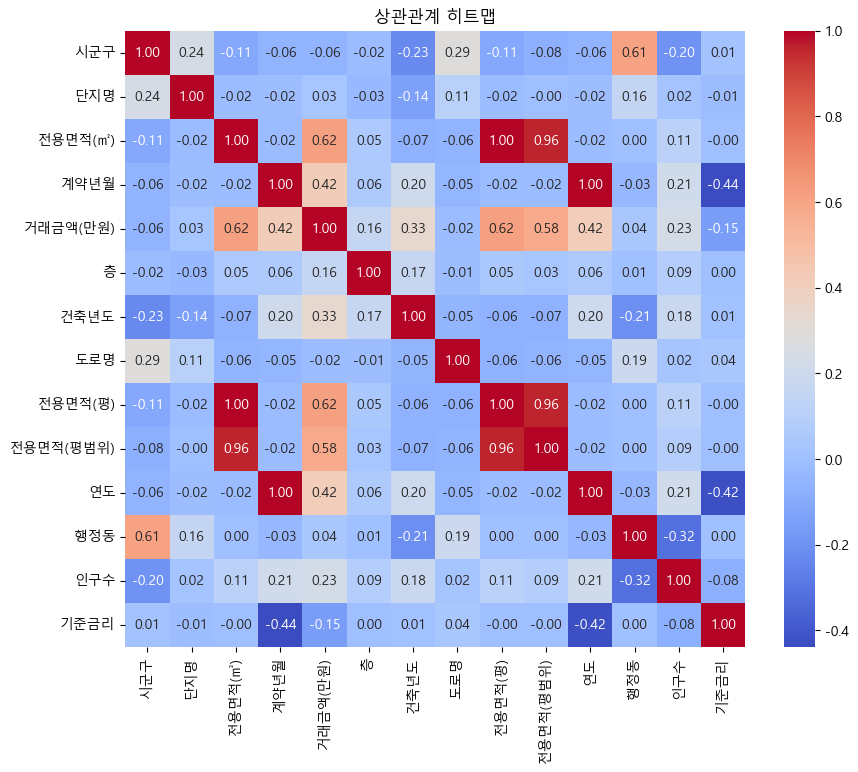

In [43]:
categorical_columns = ['시군구', '단지명', '도로명', '전용면적(평범위)', '행정동']

# 레이블 인코딩 수행
for col in categorical_columns:
    combined_df[col] = combined_df[col].astype('category').cat.codes

# 상관관계 히트맵을 그리기 위해 필요한 수치형 변수들을 선택
numeric_columns = ['시군구', '단지명', '전용면적(㎡)', '계약년월', '거래금액(만원)', '층', '건축년도', '도로명', '전용면적(평)', '전용면적(평범위)', '연도', '행정동', '인구수','기준금리']
numeric_data = combined_df[numeric_columns]

# 상관관계 행렬 계산
correlation_matrix = numeric_data.corr()

# 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("상관관계 히트맵")
plt.show()

In [44]:
combined_df.columns

Index(['시군구', '단지명', '전용면적(㎡)', '계약년월', '거래금액(만원)', '층', '건축년도', '도로명',
       '전용면적(평)', '전용면적(평범위)', '연도', '행정동', '인구수', '기준금리', '연식'],
      dtype='object')

## ■ Where
어느 동이 거래량이 많은지와 어느 동이 가격이 비쌀까?

In [45]:
dong_list = ['가능동', '금오동', '낙양동', '녹양동', '민락동', '신곡동', '용현동', '의정부동', '장암동', '호원동', '고산동', '산곡동']
mean_values = {}

for dong in dong_list:
    dong_mean_values = []  # 각 동네별로 가격 지수를 저장할 리스트 생성
    for year in years:
        standard = data_frames[f'df{year}'][data_frames[f'df{year}']['시군구'] == dong]
        standard_mean = standard['거래금액(만원)'].mean()
        dong_mean_values.append(round(standard_mean, 2))
    mean_values[dong] = dong_mean_values

print(mean_values)

{'가능동': [20507.91, 20590.47, 20953.74, 21711.32, 22195.45, 23168.39, 23819.42, 27135.12, 34310.69, 35777.56, 32723.19], '금오동': [21636.99, 21587.05, 21418.77, 21910.47, 22838.95, 23124.5, 22756.01, 24902.96, 31243.67, 33631.72, 30405.4], '낙양동': [nan, nan, 31985.42, 35137.5, 33379.27, 35049.14, 34952.62, 37414.11, 51378.12, 47057.42, 39383.84], '녹양동': [21458.58, 21622.91, 22548.68, 23703.63, 24871.13, 24756.37, 24657.47, 26008.35, 33316.92, 38073.17, 31530.0], '민락동': [17935.66, 20552.37, 20351.53, 22422.57, 22718.72, 24345.78, 26769.48, 29145.22, 36522.95, 40781.79, 34921.24], '신곡동': [18832.97, 19197.26, 19892.9, 21152.06, 21726.0, 22232.55, 22354.35, 23539.23, 30569.22, 33920.02, 31036.24], '용현동': [15269.05, 15203.34, 16682.71, 18288.67, 18356.99, 20014.87, 20058.96, 20291.84, 27395.6, 35103.44, 33738.46], '의정부동': [12143.43, 10683.66, 15051.57, 13585.61, 16230.8, 16453.05, 20482.73, 21276.88, 23353.2, 15169.29, 24104.22], '장암동': [19720.25, 19397.85, 20028.57, 20831.32, 22069.93, 23461.8

In [46]:
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
price_index = []
index_list = []

for number in numbers:
    dong_name = dong_list[number - 1]  # 각 숫자에 해당하는 동네 이름 가져오기
    if dong_name in mean_values:
        standard_mean = mean_values[dong_name]
        cacular = [round((standard_mean[i] / standard_mean[i - 1] * 100), 2) if i > 0 else dong_list[number-1] for i in range(len(standard_mean))]
        cacular = cacular[:-1]
        price_index.append(cacular)
  

# 동네 이름을 제외하고 가격 지수 리스트만 출력
for index in price_index:
    index_list.append(index)

index_list

[['가능동',
  100.4,
  101.76,
  103.62,
  102.23,
  104.38,
  102.81,
  113.92,
  126.44,
  104.28],
 ['금오동', 99.77, 99.22, 102.3, 104.24, 101.25, 98.41, 109.43, 125.46, 107.64],
 ['낙양동', nan, nan, 109.85, 95.0, 105.0, 99.72, 107.04, 137.32, 91.59],
 ['녹양동', 100.77, 104.28, 105.12, 104.93, 99.54, 99.6, 105.48, 128.1, 114.28],
 ['민락동',
  114.59,
  99.02,
  110.18,
  101.32,
  107.16,
  109.96,
  108.87,
  125.31,
  111.66],
 ['신곡동',
  101.93,
  103.62,
  106.33,
  102.71,
  102.33,
  100.55,
  105.3,
  129.86,
  110.96],
 ['용현동',
  99.57,
  109.73,
  109.63,
  100.37,
  109.03,
  100.22,
  101.16,
  135.01,
  128.14],
 ['의정부동', 87.98, 140.88, 90.26, 119.47, 101.37, 124.49, 103.88, 109.76, 64.96],
 ['장암동', 98.37, 103.25, 104.01, 105.95, 106.31, 99.64, 105.82, 135.17, 110.68],
 ['호원동', 103.18, 103.44, 105.97, 104.35, 105.7, 100.77, 106.05, 131.87, 93.02],
 ['고산동', nan, nan, nan, nan, nan, nan, nan, 75.49, 121.12],
 ['산곡동', nan, nan, nan, nan, nan, nan, nan, 105.76, 125.8]]

In [48]:
apt12 = pd.read_csv('./data/아파트(매매)__실거래가_20230801164320.csv',encoding='cp949')

apt12['시군구'].unique()

apt12['시군구'] = apt12['시군구'].apply(lambda x : x.split()[2])

apt12['시군구'].unique()


array(['가능동', '금오동', '녹양동', '민락동', '신곡동', '용현동', '의정부동', '장암동', '호원동'],
      dtype=object)

In [49]:
apt12['거래금액(만원)'] = apt12['거래금액(만원)'].str.replace(',', '').astype(int)

In [50]:
dong_list = ['가능동', '금오동', '녹양동', '민락동', '신곡동', '용현동', '의정부동', '장암동', '호원동']
com_mean_values = {}

for dong in dong_list:
    dong_mean_values = []  # 각 동네별로 가격 지수를 저장할 리스트 생성
    for year in years:
        com_standard = apt12[apt12['시군구'] == dong]
        com_standard_mean = com_standard['거래금액(만원)'].mean()
        dong_mean_values.append(round(com_standard_mean, 2))
    com_mean_values[dong] = dong_mean_values

print(com_mean_values)

dong_list = ['가능동', '금오동', '낙양동', '녹양동', '민락동', '신곡동', '용현동', '의정부동', '장암동', '호원동', '고산동', '산곡동']
mean_values = {}

for dong in dong_list:
    dong_mean_values = []  # 각 동네별로 가격 지수를 저장할 리스트 생성
    for year in years:
        standard = data_frames[f'df{year}'][data_frames[f'df{year}']['시군구'] == dong]
        standard_mean = standard['거래금액(만원)'].mean()
        dong_mean_values.append(round(standard_mean, 2))
    mean_values[dong] = dong_mean_values

print(mean_values)

# 첫 번째 동네에 해당하는 가격 지수 계산
nums = [0,1,3,4,5,6,7,8,9]
price_index_list = []
for num in nums:
    first_dong_com_mean = com_mean_values[dong_list[num]][num]
    first_dong_mean = mean_values[dong_list[num]][num]
    price_index2 = first_dong_mean / first_dong_com_mean * 100
    price_index_list.append(price_index2.round(2))


price_index_list

{'가능동': [19576.16, 19576.16, 19576.16, 19576.16, 19576.16, 19576.16, 19576.16, 19576.16, 19576.16, 19576.16, 19576.16], '금오동': [22157.16, 22157.16, 22157.16, 22157.16, 22157.16, 22157.16, 22157.16, 22157.16, 22157.16, 22157.16, 22157.16], '녹양동': [21366.57, 21366.57, 21366.57, 21366.57, 21366.57, 21366.57, 21366.57, 21366.57, 21366.57, 21366.57, 21366.57], '민락동': [17868.38, 17868.38, 17868.38, 17868.38, 17868.38, 17868.38, 17868.38, 17868.38, 17868.38, 17868.38, 17868.38], '신곡동': [18885.89, 18885.89, 18885.89, 18885.89, 18885.89, 18885.89, 18885.89, 18885.89, 18885.89, 18885.89, 18885.89], '용현동': [15444.39, 15444.39, 15444.39, 15444.39, 15444.39, 15444.39, 15444.39, 15444.39, 15444.39, 15444.39, 15444.39], '의정부동': [14771.44, 14771.44, 14771.44, 14771.44, 14771.44, 14771.44, 14771.44, 14771.44, 14771.44, 14771.44, 14771.44], '장암동': [18246.69, 18246.69, 18246.69, 18246.69, 18246.69, 18246.69, 18246.69, 18246.69, 18246.69, 18246.69, 18246.69], '호원동': [21727.27, 21727.27, 21727.27, 21727.27

[104.76, 97.43, 110.94, 127.14, 117.72, 129.88, 144.04, 183.26, 163.71]

In [51]:
index_list[0].append(104.76)
index_list[1].append(97.43)
index_list[3].append(110.94)
index_list[4].append(127.14)
index_list[5].append(117.72)
index_list[6].append(129.88)
index_list[7].append(144.04)
index_list[8].append(183.26)
index_list[9].append(163.71)

In [52]:
import numpy as np
index_list[2].append(np.nan)
index_list[10].append(np.nan)
index_list[11].append(np.nan)

In [53]:
nns = [0,1,2,3,4,5,6,7,8,9,10,11]

for nn in nns:
    index_list[nn][0], index_list[nn][-1] = index_list[nn][-1], index_list[nn][0]
    del index_list[nn][-1]
print(index_list)

[[104.76, 100.4, 101.76, 103.62, 102.23, 104.38, 102.81, 113.92, 126.44, 104.28], [97.43, 99.77, 99.22, 102.3, 104.24, 101.25, 98.41, 109.43, 125.46, 107.64], [nan, nan, nan, 109.85, 95.0, 105.0, 99.72, 107.04, 137.32, 91.59], [110.94, 100.77, 104.28, 105.12, 104.93, 99.54, 99.6, 105.48, 128.1, 114.28], [127.14, 114.59, 99.02, 110.18, 101.32, 107.16, 109.96, 108.87, 125.31, 111.66], [117.72, 101.93, 103.62, 106.33, 102.71, 102.33, 100.55, 105.3, 129.86, 110.96], [129.88, 99.57, 109.73, 109.63, 100.37, 109.03, 100.22, 101.16, 135.01, 128.14], [144.04, 87.98, 140.88, 90.26, 119.47, 101.37, 124.49, 103.88, 109.76, 64.96], [183.26, 98.37, 103.25, 104.01, 105.95, 106.31, 99.64, 105.82, 135.17, 110.68], [163.71, 103.18, 103.44, 105.97, 104.35, 105.7, 100.77, 106.05, 131.87, 93.02], [nan, nan, nan, nan, nan, nan, nan, nan, 75.49, 121.12], [nan, nan, nan, nan, nan, nan, nan, nan, 105.76, 125.8]]


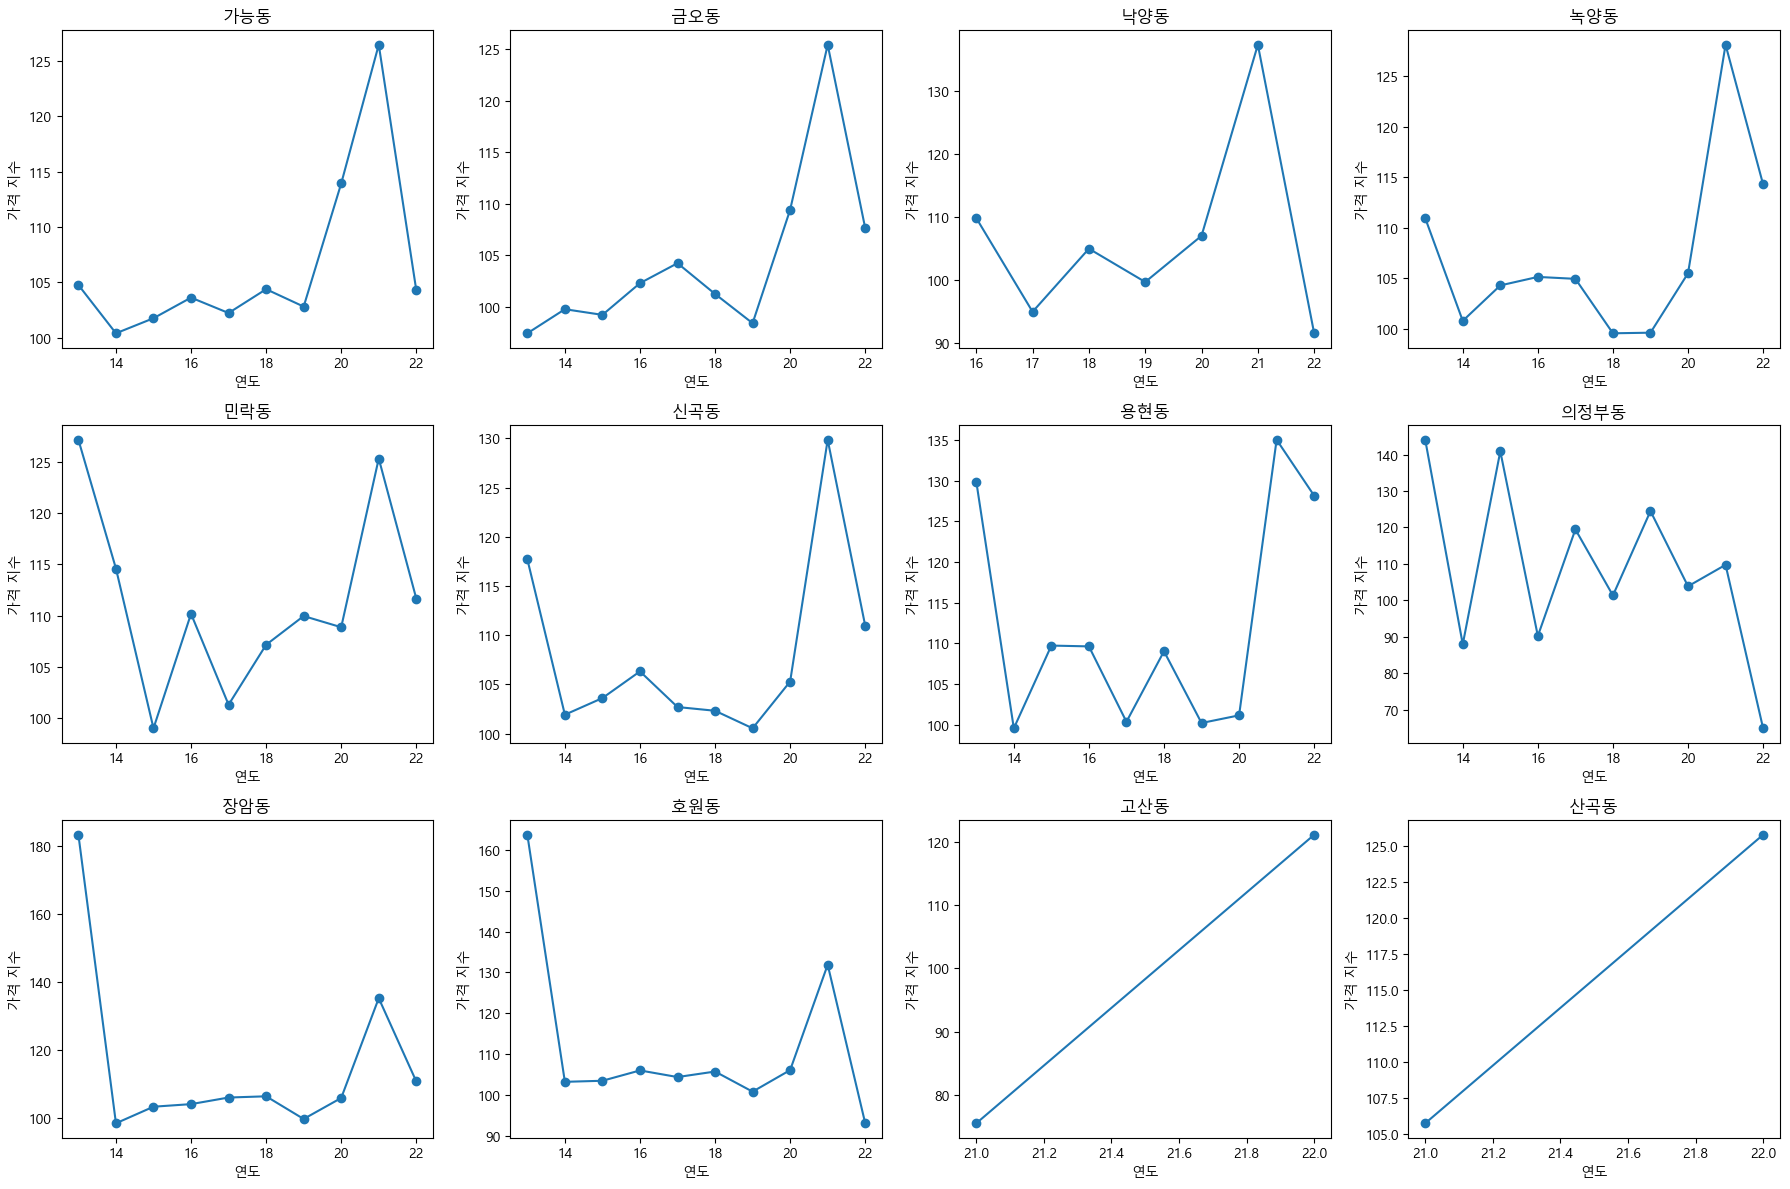

In [54]:
import matplotlib.pyplot as plt

# 서브플롯 설정
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
axs = axs.flatten()

# 각 리스트별로 시각화
for i in range(len(index_list)):
    axs[i].plot(range(13, 23), index_list[i], marker='o')
    axs[i].set_title(dong_list[i])
    axs[i].set_xlabel('연도')
    axs[i].set_ylabel('가격 지수')

plt.tight_layout()
plt.show()

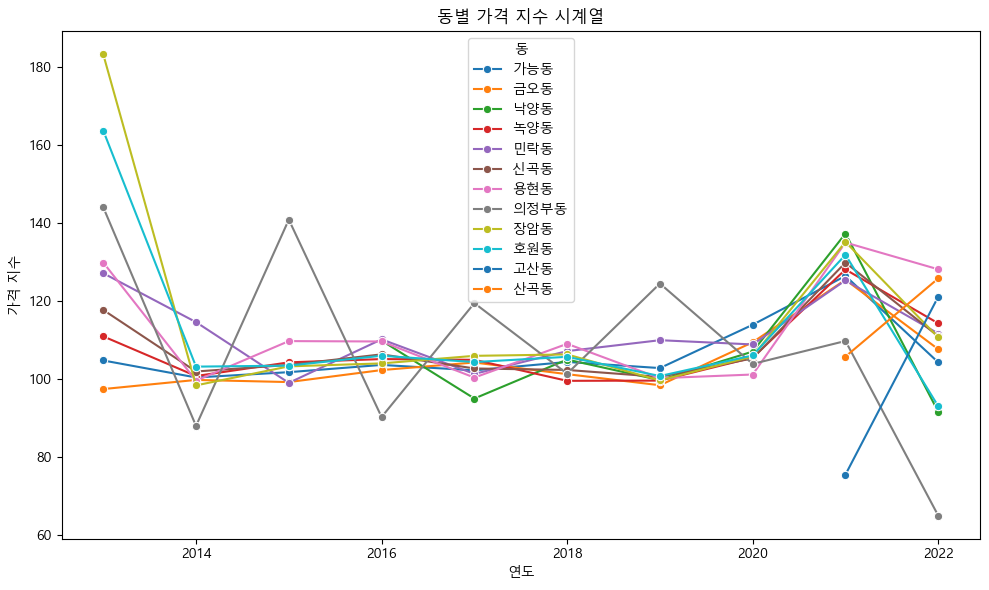

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

# 각 리스트별로 시각화
for i in range(len(index_list)):
    x_values = range(2013, 2023)
    sns.lineplot(x=x_values, y=index_list[i], marker='o', label=dong_list[i])

ax.set_title('동별 가격 지수 시계열')
ax.set_xlabel('연도')
ax.set_ylabel('가격 지수')
ax.legend(title='동')

# 그래프 출력
plt.tight_layout()
plt.show()

## ■ When
언제 거래량이 많은지?

In [56]:
trading_volume = []
for year in years :
    i = data_frames[f'df{year}'][data_frames[f'df{year}']['시군구'] == '가능동'].shape[0]
    trading_volume.append(i)
print(trading_volume)

[187, 208, 365, 340, 277, 242, 227, 464, 288, 78, 69]


In [57]:
dong_list = ['가능동', '금오동', '낙양동', '녹양동', '민락동', '신곡동', '용현동', '의정부동', '장암동', '호원동', '고산동', '산곡동']
trading_volume_by_dong = {dong: [] for dong in dong_list}

for year in years:
    df_name = f'df{year}'
    if df_name in data_frames:
        for dong in dong_list:
            filtered_data = data_frames[df_name][data_frames[df_name]['시군구'] == dong]
            trading_volume_by_dong[dong].append(filtered_data.shape[0])

print(trading_volume_by_dong)

{'가능동': [187, 208, 365, 340, 277, 242, 227, 464, 288, 78, 69], '금오동': [322, 346, 560, 531, 362, 309, 364, 726, 365, 93, 108], '낙양동': [0, 0, 12, 28, 41, 116, 168, 489, 160, 60, 99], '녹양동': [240, 261, 364, 303, 230, 204, 202, 336, 201, 41, 45], '민락동': [780, 1110, 1112, 812, 617, 938, 728, 1735, 834, 268, 346], '신곡동': [1355, 1601, 2303, 1812, 1357, 1083, 1174, 2584, 1526, 405, 407], '용현동': [489, 727, 953, 767, 658, 593, 394, 778, 500, 116, 91], '의정부동': [244, 371, 433, 341, 261, 425, 414, 468, 550, 328, 158], '장암동': [366, 354, 592, 461, 423, 302, 330, 675, 317, 78, 86], '호원동': [986, 1226, 1571, 1307, 1242, 1086, 1080, 1642, 756, 232, 228], '고산동': [0, 0, 0, 0, 0, 0, 0, 3, 51, 16, 70], '산곡동': [0, 0, 0, 0, 0, 0, 0, 4, 14, 4, 26]}


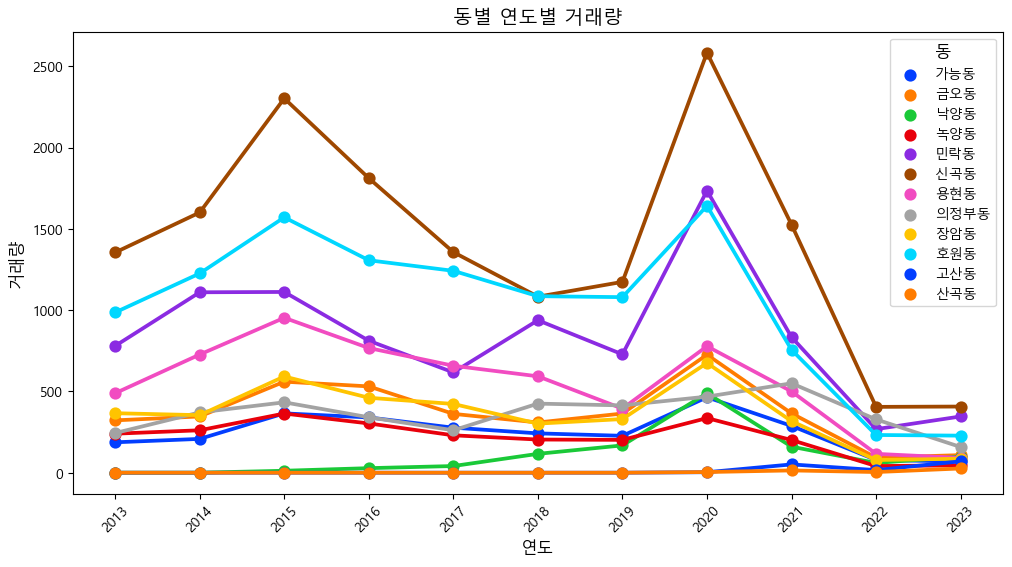

In [58]:
import seaborn as sns

# trading_volume_by_dong 딕셔너리를 데이터프레임으로 변환
df_trading_volume = pd.DataFrame(trading_volume_by_dong)

# 데이터프레임의 형태를 변환 (동별 거래량을 '연도' 열과 '거래량' 열로 변환)
df_trading_volume = df_trading_volume.reset_index().melt(id_vars='index', var_name='동', value_name='거래량')
df_trading_volume = df_trading_volume.rename(columns={'index': '연도'})

# 연도를 13부터 23까지로 변환
df_trading_volume['연도'] = df_trading_volume['연도'].astype(int) + 2013

# 그래프 그리기
plt.figure(figsize=(12, 6))
sns.pointplot(data=df_trading_volume, x='연도', y='거래량', hue='동', palette='bright')
plt.xlabel('연도', fontsize=12)
plt.ylabel('거래량', fontsize=12)
plt.title('동별 연도별 거래량', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='동', title_fontsize=12)
plt.show()

In [59]:
combined_df['연도']

0        2013
1        2013
2        2013
3        2013
4        2013
         ... 
60900    2023
60901    2023
60902    2023
60903    2023
60904    2023
Name: 연도, Length: 60905, dtype: int32

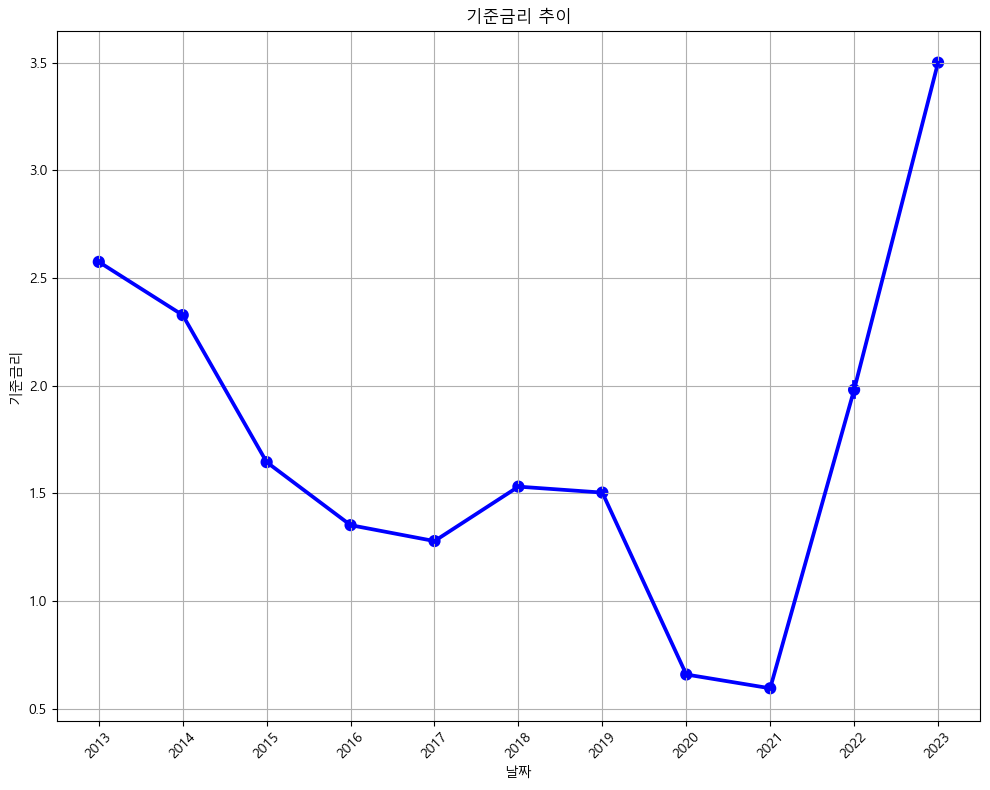

In [60]:
combined_df = combined_df.sort_values(by='연도')
plt.figure(figsize=(10, 8)) 
sns.pointplot(data=combined_df, x='연도', y='기준금리', color='blue', markers='o', linestyles='-', dodge=True)
plt.xlabel('날짜')
plt.ylabel('기준금리')
plt.title('기준금리 추이')
plt.xticks(rotation=45)  # X축 라벨 각도 설정 (선택사항)

plt.grid(True)  # 그리드 표시 (선택사항)
plt.tight_layout()  # 레이아웃 조정 (선택사항)

plt.show()

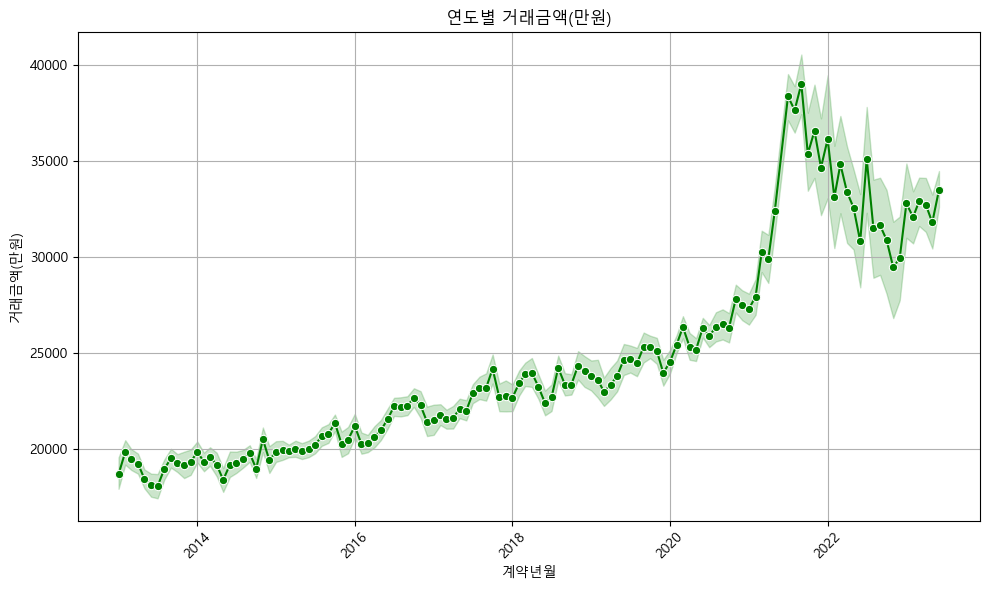

In [61]:

# '계약년월'을 날짜 형식으로 변환
combined_df['계약년월'] = pd.to_datetime(combined_df['계약년월'], format='%Y%m')

plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='계약년월', y='거래금액(만원)', marker='o', color='green')
plt.xlabel('계약년월')
plt.ylabel('거래금액(만원)')
plt.title('연도별 거래금액(만원)')
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()

plt.show()

## ■ How
어떻게 아파트 가격을 예측할까?

In [78]:
combined_df['계약년월']

0       2013-01-01
3316    2013-09-01
3315    2013-09-01
3314    2013-09-01
3313    2013-09-01
           ...    
59517   2023-01-01
59516   2023-01-01
59515   2023-01-01
59545   2023-01-01
60904   2023-05-01
Name: 계약년월, Length: 60905, dtype: datetime64[ns]

In [76]:
from sklearn.linear_model import LinearRegression

In [64]:
combined_df.describe().round(2)

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,인구수,기준금리,연식
count,60905.00,60905.00,60905.00,60905,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00,60905.00
mean,7.01,137.84,70.38,2017-11-11 02:57:46.474016768,23825.07,10.07,2001.47,150.16,21.38,1.52,2017.42,5.63,40641.82,1.53,15.95
min,0.00,0.00,10.44,2013-01-01 00:00:00,3400.00,1.00,1985.00,0.00,3.00,0.00,2013.00,0.00,18616.00,0.50,0.00
25%,5.00,74.00,59.47,2015-06-01 00:00:00,17150.00,5.00,1997.00,83.00,18.00,1.00,2015.00,3.00,30760.00,1.25,11.00
50%,7.00,127.00,63.16,2017-09-01 00:00:00,22000.00,10.00,2000.00,144.00,19.00,1.00,2017.00,5.00,37351.00,1.50,17.00
75%,10.00,220.00,84.94,2020-05-01 00:00:00,28000.00,15.00,2006.00,200.00,26.00,2.00,2020.00,9.00,46394.00,1.75,21.00
max,11.00,285.00,148.98,2023-06-01 00:00:00,96000.00,35.00,2022.00,303.00,45.00,4.00,2023.00,12.00,80866.00,3.50,37.00
std,3.03,80.85,20.83,NaN,9805.95,6.03,7.33,79.31,6.40,0.69,2.81,3.33,15510.93,0.74,7.31


In [81]:
# 시간의 흐름에 따라 정리할까봐 계약년월로 묶은 표(혹시 시계열에 쓰일까봐)
combined_df['계약년월'] = pd.to_datetime(combined_df['계약년월'], format='%Y%m')
combined_df = combined_df.drop_duplicates()

# '계약년월'을 기준으로 데이터를 그룹화하고, '거래금액(만원)'을 평균으로 요약
time_df = combined_df.groupby('계약년월').mean()


time_df = time_df.sort_index()


time_df.round(2)

,시군구,단지명,전용면적(㎡),거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,인구수,기준금리,연식
계약년월,,,,,,,,,,,,,,
2013-01-01,7.34,140.58,70.13,18654.08,10.19,1999.97,158.45,21.28,1.51,2013.0,5.87,37071.24,2.75,13.03
2013-02-01,7.23,146.96,73.25,19803.34,9.53,2000.28,163.45,22.24,1.60,2013.0,5.79,37298.81,2.75,12.72
2013-03-01,7.32,141.84,72.64,19416.97,9.37,1999.53,150.73,22.05,1.58,2013.0,5.90,37666.86,2.75,13.47
2013-04-01,7.17,137.77,72.01,19270.48,9.74,2000.18,145.67,21.88,1.58,2013.0,5.69,37333.27,2.75,12.82
2013-05-01,7.19,140.64,70.04,18560.89,10.10,1999.68,149.23,21.25,1.51,2013.0,5.69,37011.96,2.50,13.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,6.41,133.50,68.02,31943.22,11.32,2007.91,136.53,20.64,1.43,2023.0,5.03,49617.70,3.50,15.09
2023-03-01,6.36,136.34,70.60,32958.09,11.48,2006.45,141.19,21.45,1.52,2023.0,5.29,49342.76,3.50,16.55
2023-04-01,6.43,130.30,69.49,32584.98,11.71,2006.38,147.55,21.09,1.50,2023.0,5.35,47568.44,3.50,16.62


In [82]:
combined_df

,시군구,단지명,전용면적(㎡),계약년월,거래금액(만원),층,건축년도,도로명,전용면적(평),전용면적(평범위),연도,행정동,인구수,기준금리,연식
0,0,4,59.98,2013-01-01,21600,10,2007.0,124,18.0,1,2013,0,26149.0,2.75,6.0
3316,7,45,60.00,2013-09-01,15200,17,1995.0,201,18.0,1,2013,5,48702.0,2.50,18.0
3315,7,45,47.88,2013-09-01,11700,5,1995.0,201,14.0,1,2013,5,48702.0,2.50,18.0
3314,7,18,47.88,2013-09-01,12400,15,1995.0,201,14.0,1,2013,5,48702.0,2.50,18.0
3313,7,18,60.00,2013-09-01,13000,17,1995.0,201,18.0,1,2013,5,48702.0,2.50,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59517,1,12,59.91,2023-01-01,31000,10,2021.0,299,18.0,1,2023,2,50140.0,3.50,2.0
59516,1,12,59.71,2023-01-01,30500,4,2021.0,299,18.0,1,2023,2,50140.0,3.50,2.0
59515,1,12,59.51,2023-01-01,31500,3,2021.0,299,18.0,1,2023,2,50140.0,3.50,2.0
59545,5,69,84.98,2023-01-01,41300,21,2017.0,97,26.0,2,2023,3,78876.0,3.50,6.0


In [66]:
X = combined_df[['시군구', '전용면적(㎡)', '층', '건축년도','기준금리','인구수','단지명','계약년월','전용면적(평범위)','행정동','도로명']]
y = combined_df[['거래금액(만원)']]

# '거래금액(만원)' 열의 빈 문자열을 NaN으로 대체
y['거래금액(만원)'] = pd.to_numeric(y['거래금액(만원)'], errors='coerce')


X_encoded = pd.get_dummies(X, columns=['시군구','계약년월'], dtype=float)
X_encoded = pd.concat([X_encoded, X[['전용면적(㎡)', '층', '건축년도',]]], axis=1)

# 중복되는 열 이름 처리
X_encoded = X_encoded.loc[:, ~X_encoded.columns.duplicated()]

X_encoded.columns = X_encoded.columns.str.replace('시군구_', '')

In [67]:
X_encoded.columns

Index(['전용면적(㎡)', '층', '건축년도', '기준금리', '인구수', '단지명', '전용면적(평범위)', '행정동', '도로명',
       '0',
       ...
       '계약년월_2022-09-01 00:00:00', '계약년월_2022-10-01 00:00:00',
       '계약년월_2022-11-01 00:00:00', '계약년월_2022-12-01 00:00:00',
       '계약년월_2023-01-01 00:00:00', '계약년월_2023-02-01 00:00:00',
       '계약년월_2023-03-01 00:00:00', '계약년월_2023-04-01 00:00:00',
       '계약년월_2023-05-01 00:00:00', '계약년월_2023-06-01 00:00:00'],
      dtype='object', length=146)

In [68]:

# # 데이터 스케일링 (표준화)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=0)

# 선형 회귀 모델 학습
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [69]:
y_pred = lr.predict(X_test)

In [70]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

#예측값과 실제값의 차이를 제곱한 후 평균을 계산 / 예측오차 최소화
print(f"Mean Squared Error: {mse:.2f}")
# 모델이 데이터의 분산을 얼마나 잘 설명 / 1에 가까울수록 정확도에 가깝다. /종속 변수의 변동성(차이점)
print(f"R^2 Score: {r2:.2f}")
# 예측값과 실제값의 절대값 차이의 평균을 계산 / 모델의 예측이 얼마나 정확한지를 평가 
print(f'Mean Absolute Error (MAE): {mae:.2f}')
# 모델이 데이터의 분산을 얼마나 잘 설명하는지 / 1에 가까울수록 정확도에 가깝다. /입력 데이터의 분산을 얼마나 잘 설명하는지를 나타내는 지표(차이점)
print(f'Explained Variance Score (EV): {ev:.2f}')
# 평균 제곱 로그 오차 / 0에 가까울 수록 성능이 좋다
print(f'Mean Squared Logarithmic Error (MSLE): {msle:.2f}')
#예측값과 실제값의 중앙값 절대값 차이를 계산 / 이상치에 덜 민감한 지표(중앙값에 덜 민감)
print(f'Median Absolute Error (MedAE): {medae:.2f}')

Mean Squared Error: 22882586.30
R^2 Score: 0.76
Mean Absolute Error (MAE): 3283.37
Explained Variance Score (EV): 0.76
Mean Squared Logarithmic Error (MSLE): 0.05
Median Absolute Error (MedAE): 2257.94


In [74]:

from sklearn.ensemble import RandomForestRegressor


In [75]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor()
cv_scores = cross_val_score(rf, X_encoded, y, cv=5, scoring='r2')

# 각 폴드에서의 R2 스코어 출력
print("R2 Scores for each fold:", cv_scores)

# 평균 R2 스코어 계산
average_r2 = cv_scores.mean()
print("Average R2 Score:", average_r2)

rf.fit(X_train, y_train)

R2 Scores for each fold: [-2.99454676  0.91300746  0.93738699  0.42410115  0.44829231]
Average R2 Score: -0.05435176840493015


RandomForestRegressor()

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
ev = explained_variance_score(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

#예측값과 실제값의 차이를 제곱한 후 평균을 계산 / 예측오차 최소화
print(f"Mean Squared Error: {mse:.2f}")
# 모델이 데이터의 분산을 얼마나 잘 설명 / 1에 가까울수록 정확도에 가깝다. /종속 변수의 변동성(차이점)
print(f"R^2 Score: {r2:.2f}")
# 예측값과 실제값의 절대값 차이의 평균을 계산 / 모델의 예측이 얼마나 정확한지를 평가 
print(f'Mean Absolute Error (MAE): {mae:.2f}')
# 모델이 데이터의 분산을 얼마나 잘 설명하는지 / 1에 가까울수록 정확도에 가깝다. /입력 데이터의 분산을 얼마나 잘 설명하는지를 나타내는 지표(차이점)
print(f'Explained Variance Score (EV): {ev:.2f}')
# 평균 제곱 로그 오차 / 0에 가까울 수록 성능이 좋다
print(f'Mean Squared Logarithmic Error (MSLE): {msle:.2f}')
#예측값과 실제값의 중앙값 절대값 차이를 계산 / 이상치에 덜 민감한 지표(중앙값에 덜 민감)
print(f'Median Absolute Error (MedAE): {medae:.2f}')

Mean Squared Error: 4105841.32
R^2 Score: 0.96
Mean Absolute Error (MAE): 1121.11
Explained Variance Score (EV): 0.96
Mean Squared Logarithmic Error (MSLE): 0.00
Median Absolute Error (MedAE): 636.10
